     |████████████████████████████████| 1.5MB 7.4MB/s 
     |████████████████████████████████| 9.5MB 23.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


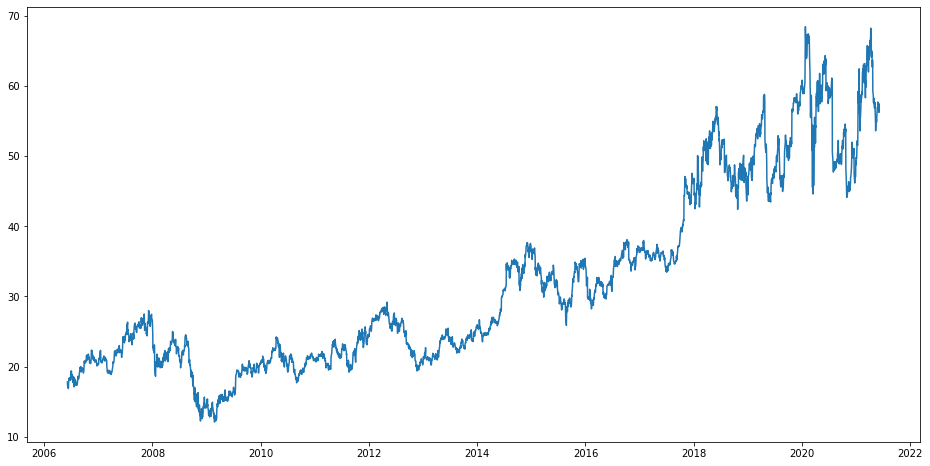

In [1]:
#import packages
import pandas as pd
import numpy as np
import itertools
! pip install pmdarima
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/MyDrive/8_semestr/diplom/INTC.csv')

#print the head
df.head()
splitter=3600
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [2]:
import pmdarima as pm

data = df.sort_index(ascending=True, axis=0)

train = data[:splitter]
valid = data[splitter:]

training = train['Close']
validation = valid['Close']

model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=9.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=9866.627, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8872.946, Time=1.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9765.380, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8415.931, Time=7.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=16.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.93 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=8529.675, Time=1.81 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8403.502, Time=4.54 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=8847.825, Time=1.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=23.08 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=11.93 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=8386.677, Time=4.33 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=883

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [3]:
forecast = model.predict(n_periods=len(data)-splitter)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [4]:
from sklearn.metrics import r2_score
print(r2_score(np.array(valid['Close']), np.array(forecast['Prediction'])))
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
# rms

0.2111815669558369


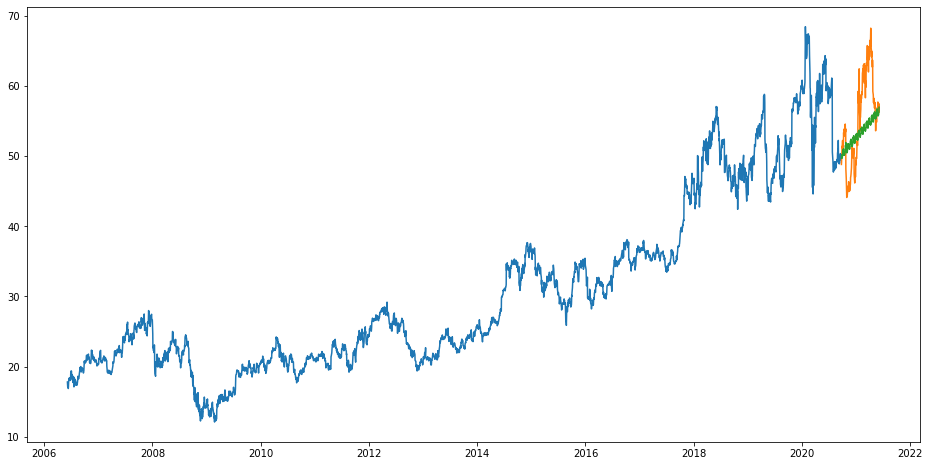

In [5]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [11]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:splitter]
valid = new_data[splitter:]
# Generate all combinations of parameters

#fit the model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
#rmse
forecast_valid = forecast['yhat'][splitter:]
print(r2_score(np.array(valid['y']),np.array(forecast_valid)))
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

-0.23656165852756894


7.097173671294267

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



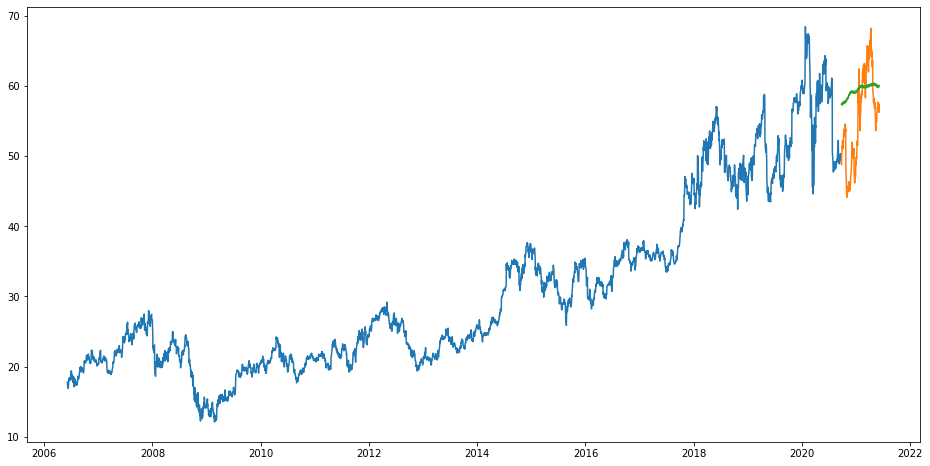

In [13]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.figure(figsize=(16,8))
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:splitter,:]
valid = dataset[splitter:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 50, batch_size = 32)
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50))
# model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Epoch 1/50
111/111 [==============================] - 34s 60ms/step - loss: 0.0295
Epoch 2/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0029
Epoch 3/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0026
Epoch 4/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0030
Epoch 5/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0020
Epoch 6/50
111/111 [==============================] - 7s 60ms/step - loss: 0.0019
Epoch 7/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0018
Epoch 8/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0017
Epoch 9/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0016
Epoch 10/50
111/111 [==============================] - 7s 60ms/step - loss: 0.0018
Epoch 11/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0015
Epoch 12/50
111/111 [==============================] - 7s 59ms/step - loss: 0.0012
Epoch 13/50


In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
# print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)


[[[0.81911685]
  [0.84678136]
  [0.82869303]
  ...
  [0.67050893]
  [0.66749424]
  [0.67157298]]

 [[0.84678136]
  [0.82869303]
  [0.8343678 ]
  ...
  [0.66749424]
  [0.67157298]
  [0.65153395]]

 [[0.82869303]
  [0.8343678 ]
  [0.84163859]
  ...
  [0.67157298]
  [0.65153395]
  [0.65756339]]

 ...

 [[0.84713597]
  [0.89714483]
  [0.88969674]
  ...
  [0.80954068]
  [0.79872315]
  [0.79464441]]

 [[0.89714483]
  [0.88969674]
  [0.90849442]
  ...
  [0.79872315]
  [0.79464441]
  [0.80510727]]

 [[0.88969674]
  [0.90849442]
  [0.90122364]
  ...
  [0.79464441]
  [0.80510727]
  [0.7831176 ]]]


In [ ]:
closing_price = model.predict(X_test)
print(closing_price.shape)
closing_price = scaler.inverse_transform(closing_price)

(176, 1)


In [ ]:
print(r2_score(valid,closing_price))
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.9292759639941917


1.6973095813872638

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



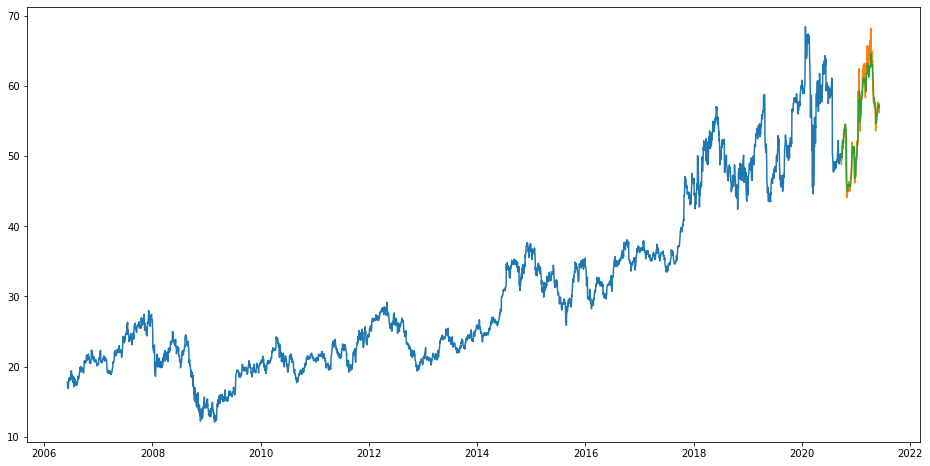

In [ ]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [ ]:
from keras.layers import GRU
from keras.optimizers import SGD

my_GRU_model = Sequential()
# First GRU layer with Dropout regularisation
my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Second GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))

# Third GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Fourth GRU layer
my_GRU_model.add(GRU(units=50, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# The output layer
my_GRU_model.add(Dense(units=1))
# Compiling the RNN
my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
my_GRU_model.fit(x_train,y_train,epochs=100,batch_size=150, verbose=1)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predictions = my_GRU_model.predict(X_test)
GRU_predictions = scaler.inverse_transform(GRU_predictions)

Epoch 1/100
24/24 [==============================] - 10s 61ms/step - loss: 0.1053
Epoch 2/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0397
Epoch 3/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0143
Epoch 4/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0029
Epoch 5/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0025
Epoch 6/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0022
Epoch 7/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0021
Epoch 8/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0020
Epoch 9/100
24/24 [==============================] - 1s 62ms/step - loss: 0.0019
Epoch 10/100
24/24 [==============================] - 1s 62ms/step - loss: 0.0020
Epoch 11/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0020
Epoch 12/100
24/24 [==============================] - 1s 61ms/step - loss: 0.0019
Epoch 13/100
24/24 [====

In [ ]:
# print(GRU_predictions)
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], GRU_predictions, squared=False)
print(r2_score(valid["Close"],GRU_predictions))
# print(rms)
# print(GRU_predictions[100:])
# print(valid)
# print(GRU_predictions.shape)
rms


0.8187474216198635


2.717187707524915

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



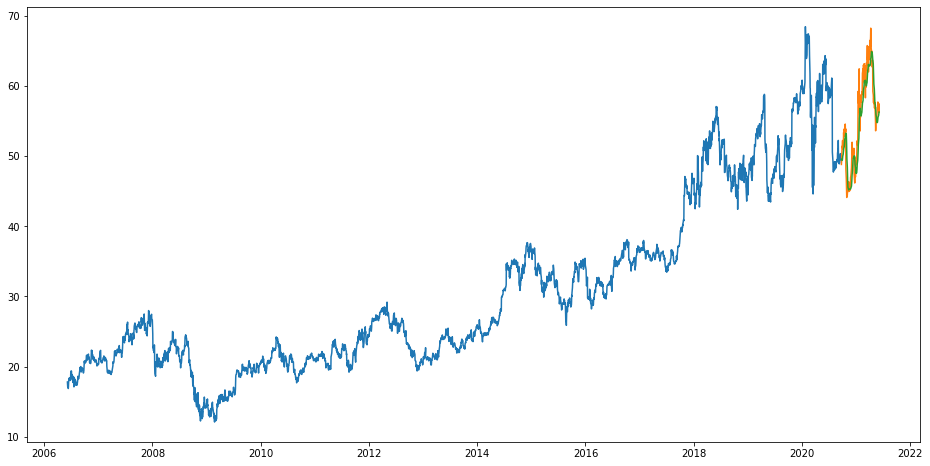

In [ ]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = GRU_predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

Real prediiction with LSTM

[0.8191168501663975, 0.8467813646607314, 0.8286930337170946, 0.834367798645721, 0.8416385912105233, 0.8198262135161161, 0.8251463056367034, 0.8217768607594103, 0.841461219339223, 0.8246143141582849, 0.831707734851787, 0.8325943991382443, 0.8345450995824597, 0.8497960480617832, 0.8701897699913146, 0.8622096140767936, 0.8684163527501978, 0.8568895396898468, 0.682922491879367, 0.6648341786693708, 0.6589821128040059, 0.6382337180664353, 0.6368150623015596, 0.6322042803297698, 0.6423124376252449, 0.6570313946261501, 0.6533072769408179, 0.6471005382674138, 0.6375243547167164, 0.6586274222623263, 0.6403617371810297, 0.6580953775829868, 0.6469232195970345, 0.6527752854623996, 0.6534846488121182, 0.6485192649668512, 0.6428445000382248, 0.6577406870413072, 0.6596914052191629, 0.6572086955628889, 0.6623514690130969, 0.6644794881276912, 0.661819495268319, 0.680085109415054, 0.689306620157712, 0.686469237693399, 0.7123603349466159, 0.6793757460653351, 0.6738783707416498, 0.6531299760040792, 0.66572

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



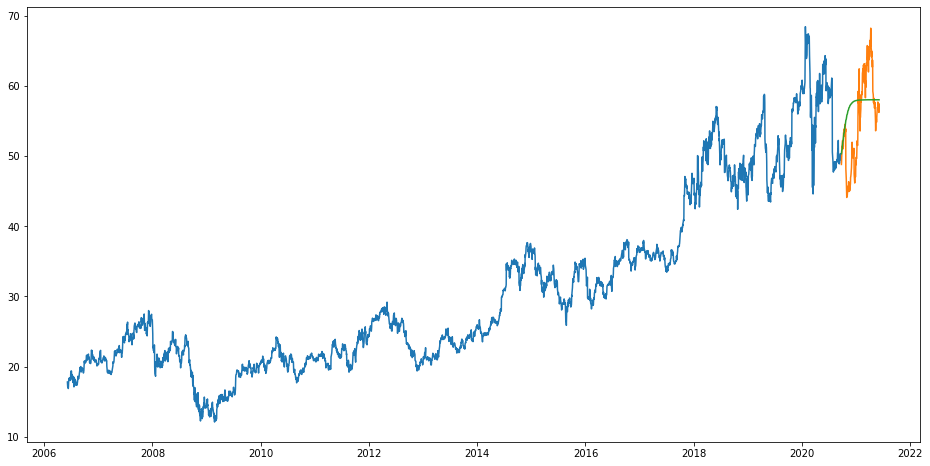

In [ ]:
from numpy import array
x_input=scaled_data[splitter-60:splitter,:].reshape(1,-1)

temp_input1=list(x_input)
temp_input1=temp_input1[0].tolist()
print((temp_input1))
temp2=np.array(temp_input1)
lst_output1=[]
n_steps1=60
i=0
while(i<len(scaled_data)-splitter):
    
    if(len(temp_input1)>60):
        #print(temp_input)
        x_input=np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat1 = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat1))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1=temp_input1[1:]
        #print(temp_input)
        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat1 = model.predict(x_input, verbose=0)
        print(yhat1[0])
        temp_input1.extend(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1
    

print("lst:", lst_output1)
predictions = scaler.inverse_transform(lst_output1)

from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))
rms
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [ ]:
from numpy import array
x_input=scaled_data[splitter-60:splitter,:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print((temp_input))
temp2=np.array(temp_input)
# print(scaler.inverse_transform(temp2.reshape(-1,1)))

[0.8191168501663975, 0.8467813646607314, 0.8286930337170946, 0.834367798645721, 0.8416385912105233, 0.8198262135161161, 0.8251463056367034, 0.8217768607594103, 0.841461219339223, 0.8246143141582849, 0.831707734851787, 0.8325943991382443, 0.8345450995824597, 0.8497960480617832, 0.8701897699913146, 0.8622096140767936, 0.8684163527501978, 0.8568895396898468, 0.682922491879367, 0.6648341786693708, 0.6589821128040059, 0.6382337180664353, 0.6368150623015596, 0.6322042803297698, 0.6423124376252449, 0.6570313946261501, 0.6533072769408179, 0.6471005382674138, 0.6375243547167164, 0.6586274222623263, 0.6403617371810297, 0.6580953775829868, 0.6469232195970345, 0.6527752854623996, 0.6534846488121182, 0.6485192649668512, 0.6428445000382248, 0.6577406870413072, 0.6596914052191629, 0.6572086955628889, 0.6623514690130969, 0.6644794881276912, 0.661819495268319, 0.680085109415054, 0.689306620157712, 0.686469237693399, 0.7123603349466159, 0.6793757460653351, 0.6738783707416498, 0.6531299760040792, 0.66572

In [ ]:
lst_output=[]
n_steps=60
i=0
while(i<len(scaled_data)-splitter):
    
    if(len(temp_input)>60):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = my_GRU_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = my_GRU_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    



[0.6644716]
61
1 day input [0.84678136 0.82869303 0.8343678  0.84163859 0.81982621 0.82514631
 0.82177686 0.84146122 0.82461431 0.83170773 0.8325944  0.8345451
 0.84979605 0.87018977 0.86220961 0.86841635 0.85688954 0.68292249
 0.66483418 0.65898211 0.63823372 0.63681506 0.63220428 0.64231244
 0.65703139 0.65330728 0.64710054 0.63752435 0.65862742 0.64036174
 0.65809538 0.64692322 0.65277529 0.65348465 0.64851926 0.6428445
 0.65774069 0.65969141 0.6572087  0.66235147 0.66447949 0.6618195
 0.68008511 0.68930662 0.68646924 0.71236033 0.67937575 0.67387837
 0.65312998 0.66572084 0.65401664 0.65969141 0.6619968  0.67245964
 0.67902107 0.67813441 0.67050893 0.66749424 0.67157298 0.66447163]
1 day output [[0.6646068]]
2 day input [0.82869303 0.8343678  0.84163859 0.81982621 0.82514631 0.82177686
 0.84146122 0.82461431 0.83170773 0.8325944  0.8345451  0.84979605
 0.87018977 0.86220961 0.86841635 0.85688954 0.68292249 0.66483418
 0.65898211 0.63823372 0.63681506 0.63220428 0.64231244 0.6570313

In [ ]:
# print(lst_output)
predictions = scaler.inverse_transform(lst_output)
# print(predictions)
# lst_output=np.array(predictions)
# print(predictions.shape)
# print((lst_output))
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))
rms

-2.7194579357148387


12.308846912437502

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



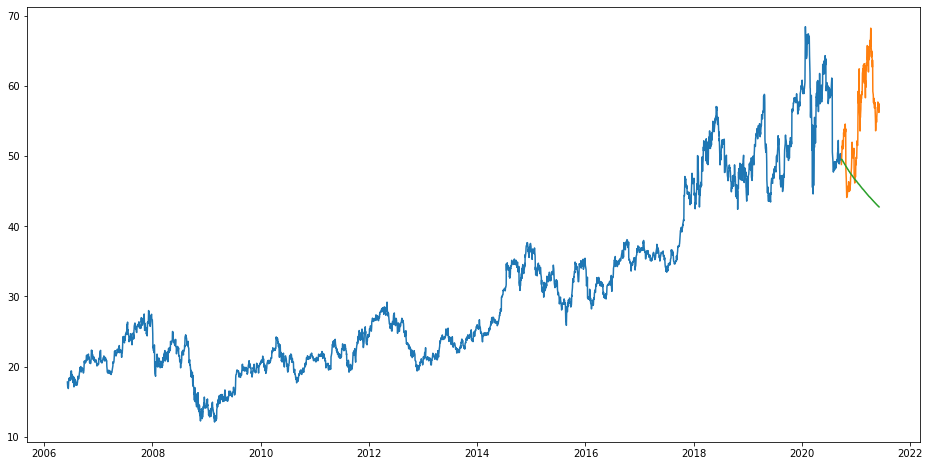

In [ ]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])